# Cricket Player Classification

The purpose of this work is to try and classify players into either batsmen, bowlers, all rounders or keepers.

We first setup some initial imports:

In [74]:
import json
import requests
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from pprint import pprint
from voronoi import plot_voronoi

# show matplotlib figures inline
%matplotlib inline

plt.rc('figure', figsize=(12, 8), dpi=250)
plt.rc('font', size=12)


## Data Collection
To carry out this work we will need to collect some training data. This will involve using the Play-Cricket system as a source of all player statistics. Data will be collected from the past two years of players history.

### Classifications
Initially we need to get classifications of players, to train the model. To do this we shall use a current fantasy league system called `Fantasy Club Cricket`. Here club members have already carried out a manual classification of players in their club. This will allow us to get a much larger data set that origionally possible.

To do this we shall analyse all clubs accessible on Play-Cricket that also have a fantasy league set up. For the purposes of this experiment, we shall limit the clubs to those who play in Warwickshire Cricket League. The clubs and their Play-Cricket IDs can be found in the `fantasyclubs.csv` file.

In [2]:
fantasyclubs_df = pd.read_csv('fantasyclubs.csv')
fantasyclubs_df

,pc_id,fantasyclubcricketslug
0,3808,knowle-village
1,137,rugby
2,4242,marston-green
3,5625,sheldon-marlborough
4,4884,olton
5,5995,standard
6,2043,corley
7,5756,solimun
8,701,ambleside
9,6749,weoley-hill


Once we have the clubs we are able to download the players classifications from Fantasy Club Cricket using the following, the output is stored in `saved_players.csv`:

In [3]:
def get_page(slug):
    page = requests.get('https://{}.fantasyclubcricket.co.uk/includes/playerlist.php'.format(slug))
    return json.loads(page.content)

saved_players_df = pd.DataFrame()
for index, club in fantasyclubs_df.iterrows():
    data = get_page(club['fantasyclubcricketslug'])
    club_df = pd.DataFrame(data)
    club_df.drop(columns=[
        'id', 'position_id',
        'total_points', 'week_points',
        'selected', 'transfer_selected',
        'club_name', 'percentage_selected_by',
        'selling_price', 'name'
    ], inplace=True)
    club_df['club_id'] = club['pc_id']
    saved_players_df = pd.concat([saved_players_df, club_df])

saved_players_df['pc_id'] = saved_players_df['pc_id'].astype('int64')
saved_players_df['club_id'] = saved_players_df['club_id'].astype('int64')
saved_players_df.to_csv('saved_players.csv', index=False)
saved_players_df

,pc_id,position_name,value,club_id
0,58831,Batter,6.0,3808
1,4047187,Batter,6.0,3808
2,3922000,Batter,6.0,3808
3,16396,Batter,6.0,3808
4,4083006,Batter,6.0,3808
5,16401,Batter,5.5,3808
6,16398,Batter,5.0,3808
7,3599192,Batter,5.0,3808
8,1008743,Batter,5.0,3808
9,438958,Batter,5.0,3808


### Player Statistics

We also need statistics of players to be able to draw out features to use in the classifier.

To do this, we add all clubs to a django app with django-cricket and django-cricket-playcricket-link installed. Add all these clubs (as home clubs) aswell as the teams at that club. Then run the management commands fetchmatchdetails followed by fetchresultdetails. This populates the database with matches of all the clubs, as well as the performances of all players.

We can then use an SQL query to retrieve the stats for each player:

Match count:
```sql
select 
id,
player_pc_id,
club_pc_id,
match_count,
if (basic_stats.no_outs = 0, '-', basic_stats.bat_runs/basic_stats.no_outs) as bat_average,
avg_bat_position,
bat_high_score,
bowl_overs/match_count as overs_per_game,
if (basic_stats.bowl_wickets = 0, '-', basic_stats.bowl_runs/basic_stats.bowl_wickets) as bowl_average,
if (basic_stats.bowl_overs = 0, '-', basic_stats.bowl_runs/basic_stats.bowl_overs) as bowl_economy

from (

	select 
		core_player.id as id,
		playcricketlink_player.pc_id as player_pc_id,
		playcricketlink_club.pc_id as club_pc_id,
		count(1) as match_count,
		
		/*bowling stats*/
		sum(`core_batperformance`.`bat`) - sum(CASE `core_batperformance`.`bat_how_out` WHEN 'no' THEN 1 ELSE 0 END) as no_outs,
		sum(`core_batperformance`.`bat_runs`) as bat_runs,
		avg(`core_batperformance`.`bat_position`) as avg_bat_position,
		max(`core_batperformance`.`bat_runs`) as bat_high_score,
		
		/*bowling stats*/
		sum(`core_bowlperformance`.`bowl_overs`) as bowl_overs,
		sum(`core_bowlperformance`.`bowl_runs`) as bowl_runs,
		sum(`core_bowlperformance`.`bowl_wickets_total`) as bowl_wickets
	from 
		`playcricketlink_player`
		inner join `core_player`          on `core_player`.`id`=`playcricketlink_player`.`link_id` 
		inner join `core_batperformance`  on `core_batperformance`.`player_id`=`core_player`.`id` 
		inner join `core_bowlperformance` on `core_bowlperformance`.`player_id`=`core_player`.`id` 
		inner join `core_club`            on `core_club`.`id`=`core_player`.`club_id`
		inner join `playcricketlink_club` on `core_club`.`id`=`playcricketlink_club`.`link_id`    
	where 
		`core_bowlperformance`.`match_id`=`core_batperformance`.`match_id`
		and core_player.id<>1
		and bat=true 
		and bowl=true
	group by 
		core_player.id
	having 
		match_count > 10
) as basic_stats

having
bat_average<>'-'
and
bowl_average<>'-'
and
bowl_economy<>'';

```




The results of this query are stored in `player_stats_over_10_games.csv`. We can now load this file:

In [146]:
player_stats_df = pd.read_csv('players_stats_over_10_games.csv')
player_stats_df.rename(columns={'player_pc_id': 'pc_id', 'club_pc_id':'club_id'}, inplace=True)
player_stats_df

,id,pc_id,club_id,match_count,bat_average,avg_bat_position,overs_per_game,wickets_per_over
0,2,293576,3540,26,12.3077,5.7692,3.053846,0.188917
1,3,64736,3540,30,11.0667,2.3333,0.016667,4.000000
2,4,3563279,3540,27,32.8519,4.0000,1.944444,0.285714
3,5,15671,3540,29,22.2069,4.4828,4.396552,0.211765
4,6,64739,3540,32,8.4688,6.1250,0.000000,0.000000
5,7,64780,3540,20,13.3500,5.5000,9.325000,0.182306
6,8,15669,3540,30,35.9333,2.5667,5.993333,0.216908
7,9,69774,3540,28,12.2857,3.2143,0.035714,0.000000
8,10,15667,3540,30,9.6000,3.8333,0.000000,0.000000
9,11,15665,3540,29,8.1034,7.5862,7.448276,0.212963


### Data Preparation
We now need to join the `saved_players_df`, and the `player_stats_df`:

In [147]:
stats_labels_df = player_stats_df.merge(saved_players_df, how='inner', on=['pc_id', 'club_id'])
stats_labels_df.drop(columns=['id', 'pc_id', 'club_id', 'match_count', 'value'], inplace=True)
stats_labels_df = stats_labels_df[stats_labels_df['position_name'] != 'Keeper']
stats_labels_df = stats_labels_df[stats_labels_df['wickets_per_over'] < 2]
stats_labels_df

,bat_average,avg_bat_position,overs_per_game,wickets_per_over,position_name
0,12.3077,5.7692,3.053846,0.188917,Batter
3,22.2069,4.4828,4.396552,0.211765,Batter
4,8.4688,6.1250,0.000000,0.000000,Batter
5,13.3500,5.5000,9.325000,0.182306,Bowler
6,35.9333,2.5667,5.993333,0.216908,All Rounder
7,12.2857,3.2143,0.035714,0.000000,Batter
8,9.6000,3.8333,0.000000,0.000000,Batter
9,8.1034,7.5862,7.448276,0.212963,Bowler
10,2.1379,10.6552,10.000000,0.175862,Bowler
11,19.3667,3.9333,0.100000,0.000000,Batter


We will now shuffle the data and map the position_name to integers

In [161]:
shuffled_stats_labels_df = shuffle(stats_labels_df)
shuffled_stats_labels_df.reset_index(drop=True, inplace=True)
shuffled_stats_labels_df['position_name'] = shuffled_stats_labels_df['position_name'].map({'Batter': 0, 'Bowler': 1, 'All Rounder': 2})
stats_labels = shuffled_stats_labels_df.to_numpy()
shuffled_stats_labels_df


,bat_average,avg_bat_position,overs_per_game,wickets_per_over,position_name
0,3.2857,9.8571,8.142857,0.298246,1
1,4.1905,7.8810,4.438095,0.241416,1
2,22.9500,2.4500,0.000000,0.000000,0
3,20.6333,3.4667,0.970000,0.240550,0
4,2.5143,9.7714,6.574286,0.186875,1
5,4.0000,6.0909,3.000000,0.121212,1
6,0.9333,10.4667,4.116667,0.186235,1
7,5.1176,6.2353,4.000000,0.176471,0
8,4.0000,6.0909,3.000000,0.121212,0
9,16.7059,7.0000,8.588235,0.205479,1


We can now split the data into a train and test data set:

In [162]:
train_set = stats_labels[:500, :4]
train_labels = stats_labels[:500, 4]
test_set = stats_labels[500:, :4]
test_labels = stats_labels[500:, 4]

## Feature Selection
We are now able to attempt feature selection

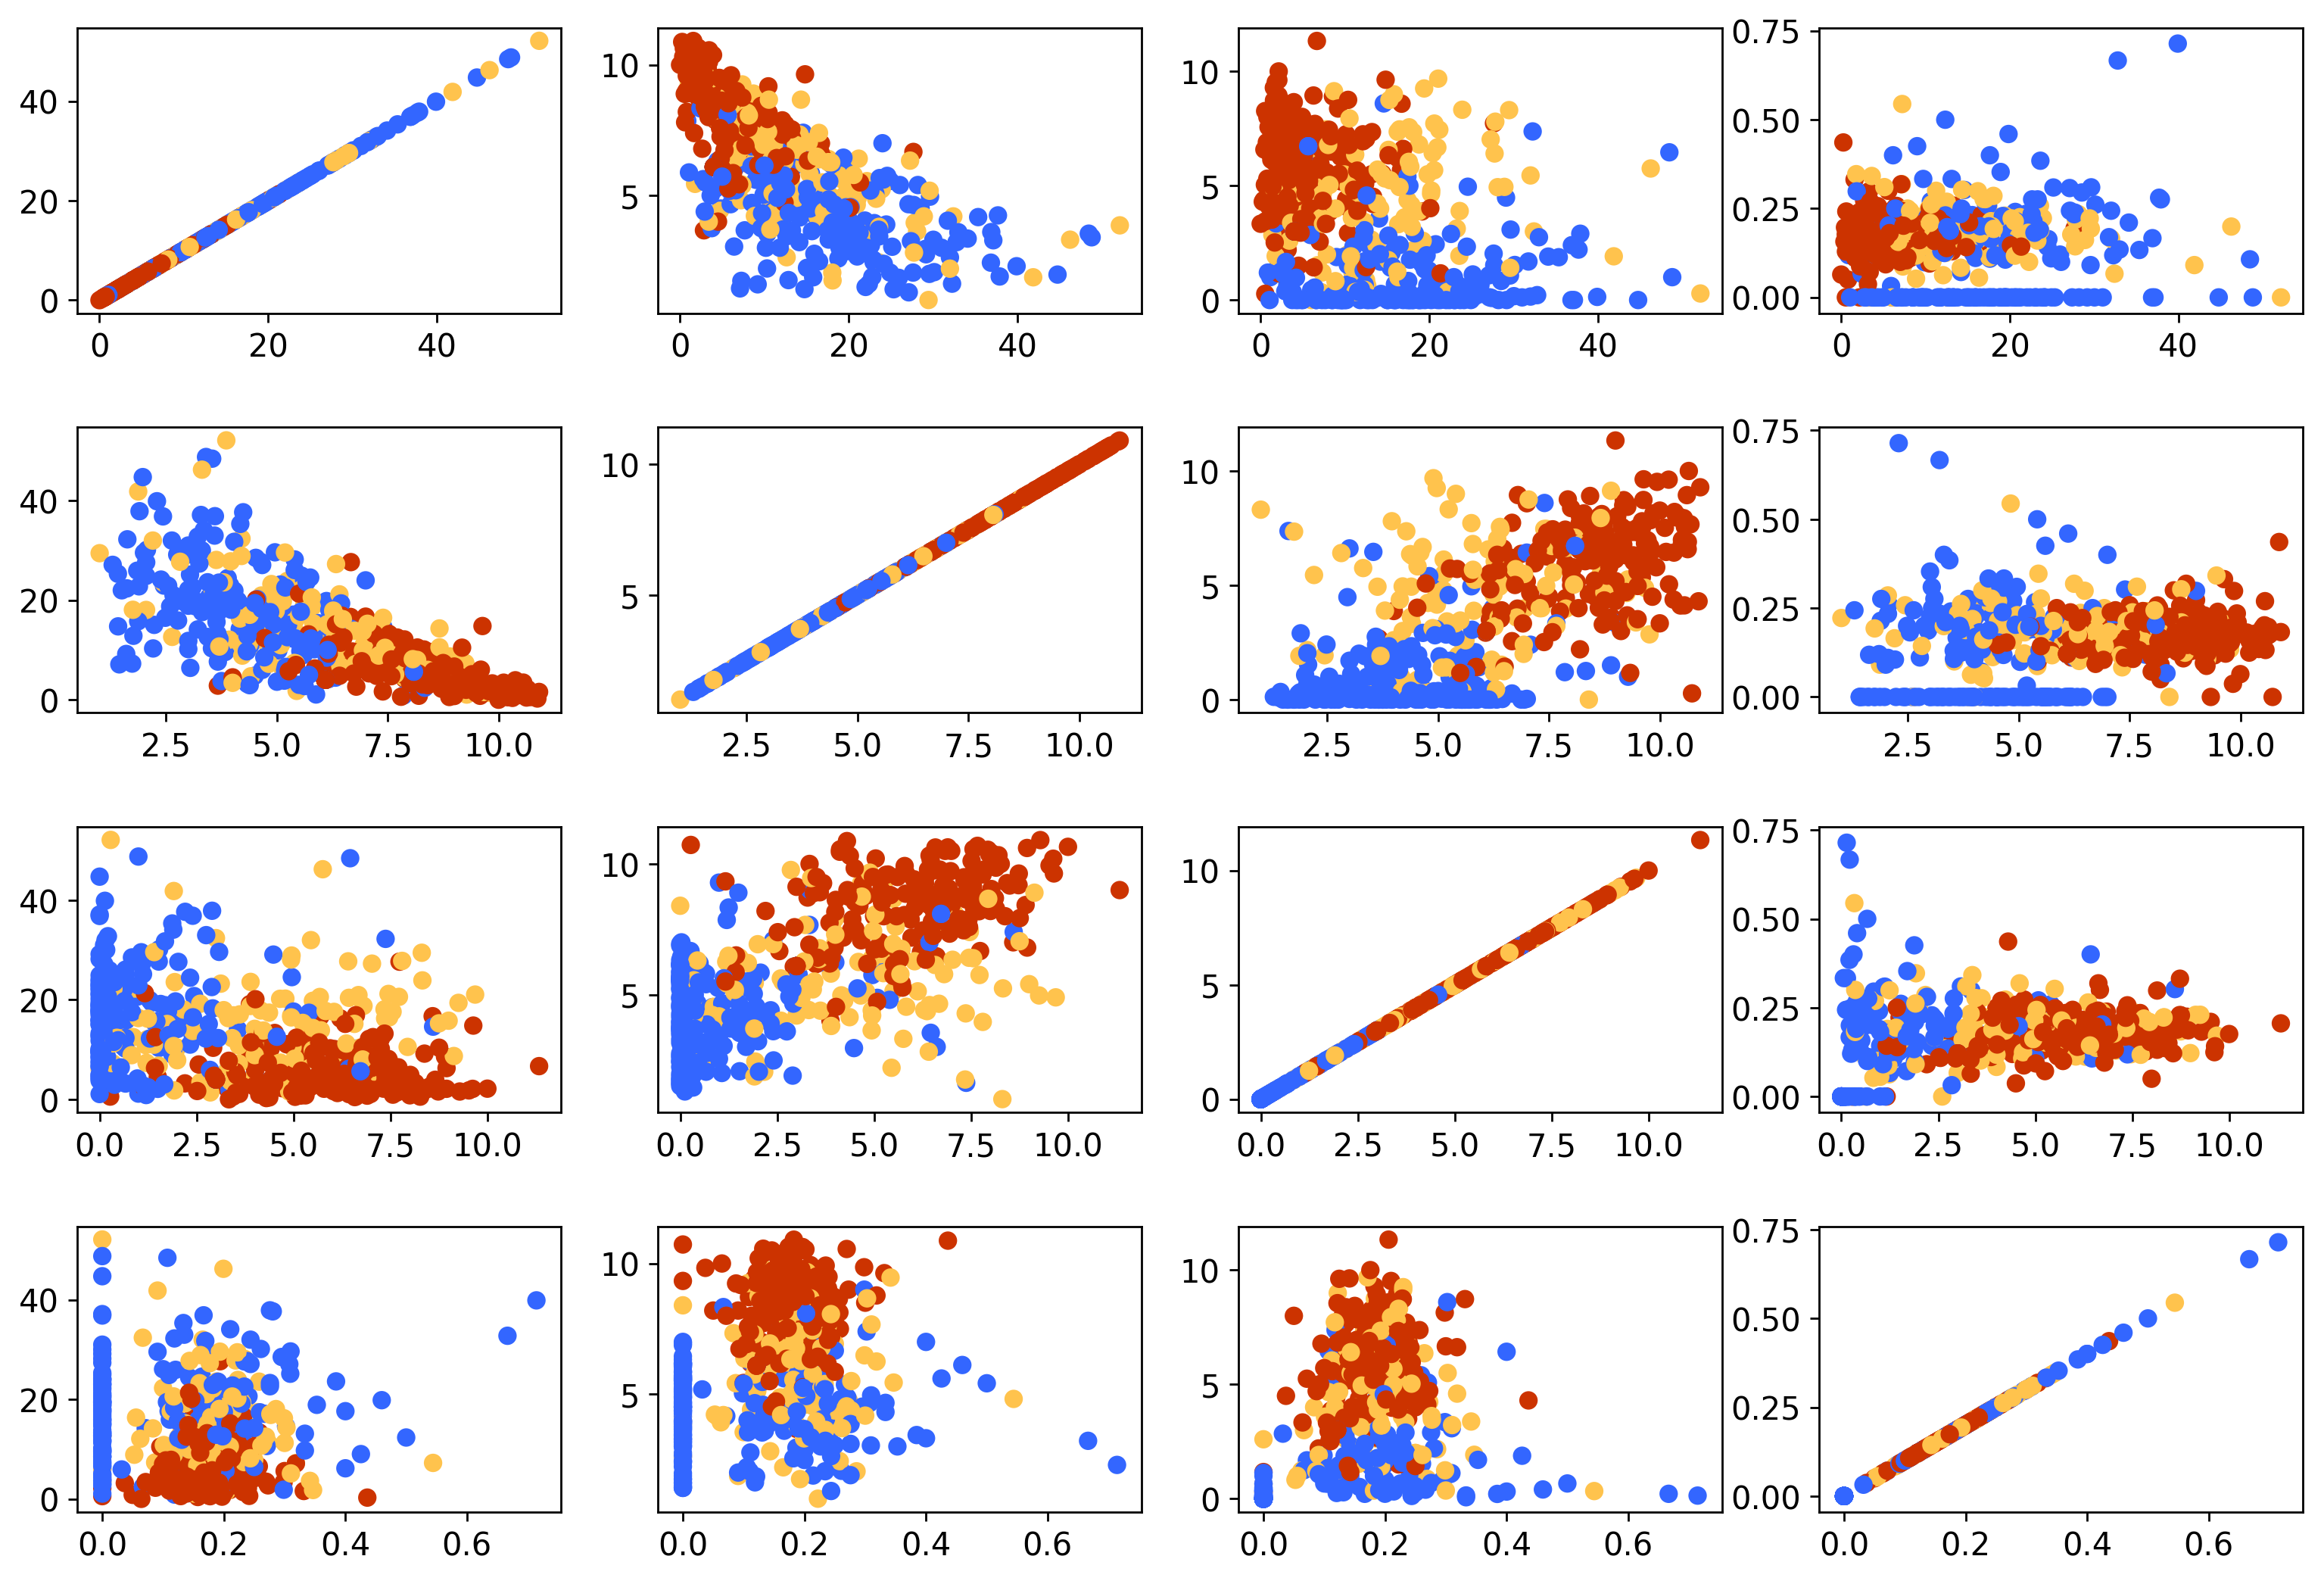

In [163]:
class_1_colour = r'#3366ff'  # bat = blue
class_2_colour = r'#cc3300'  # bowl = red
class_3_colour = r'#ffc34d'  # all rounder = yellow

class_colours = [class_1_colour, class_2_colour, class_3_colour]

def colour_map(cls):
    return class_colours[int(cls)]



n_features = train_set.shape[1]
fig, ax = plt.subplots(n_features, n_features)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.4)

for i in range(n_features):
    for j in range(n_features):
        ax[i][j].scatter(train_set[:,i], train_set[:,j], c=np.array([colour_map(cls) for cls in train_labels]))
plt.show()

### Choice

We will investigate two diferent choices of features:

- 1 vs 3
- 2 vs 3

## Classification

We are now able to test our classifier using the test set.

First, we reduced our data set to the 2 selected features.

In [164]:
reduced_train_set_1 = np.array([train_set[:, 0], train_set[:, 2], train_labels]).T
reduced_train_set_2 = np.array([train_set[:, 1], train_set[:, 2], train_labels]).T
reduced_test_set_1 = np.array([test_set[:, 0], test_set[:, 2], test_labels]).T
reduced_test_set_2 = np.array([test_set[:, 1], test_set[:, 2], test_labels]).T



### Nearest Centroid Classifier

We will now attempt to use the NCC to classify. First we calculate the centroids.

In [165]:
def get_centroid(a):
    length = a.shape[0]
    sum_x = np.sum(a[:, 0])
    sum_y = np.sum(a[:, 1])
    return (sum_x/length, sum_y/length)


centroid_class_1_1 = get_centroid(np.array([x for x in reduced_train_set_1 if x[2] == 0 ]))
centroid_class_2_1 = get_centroid(np.array([x for x in reduced_train_set_1 if x[2] == 1 ]))
centroid_class_3_1 = get_centroid(np.array([x for x in reduced_train_set_1 if x[2] == 2 ]))

centroids_1 = np.array([centroid_class_1_1, centroid_class_2_1, centroid_class_3_1])

centroid_class_1_2 = get_centroid(np.array([x for x in reduced_train_set_2 if x[2] == 0 ]))
centroid_class_2_2 = get_centroid(np.array([x for x in reduced_train_set_2 if x[2] == 1 ]))
centroid_class_3_2 = get_centroid(np.array([x for x in reduced_train_set_2 if x[2] == 2 ]))

centroids_2 = np.array([centroid_class_1_2, centroid_class_2_2, centroid_class_3_2])

We can now classify the test data to enable us to evaluate how good the classifier is.

In [166]:
def classify(p, centroids):
    distances = [np.hypot(p[0] - c[0], p[1] - c[1]) for c in centroids]
    return np.argmin(distances)


test_set_results_1 = [classify(x, centroids_1) for x in reduced_test_set_1]
test_set_results_2 = [classify(x, centroids_2) for x in reduced_test_set_2]


We shall plot a veroni graph to give a visual judge of the classifier

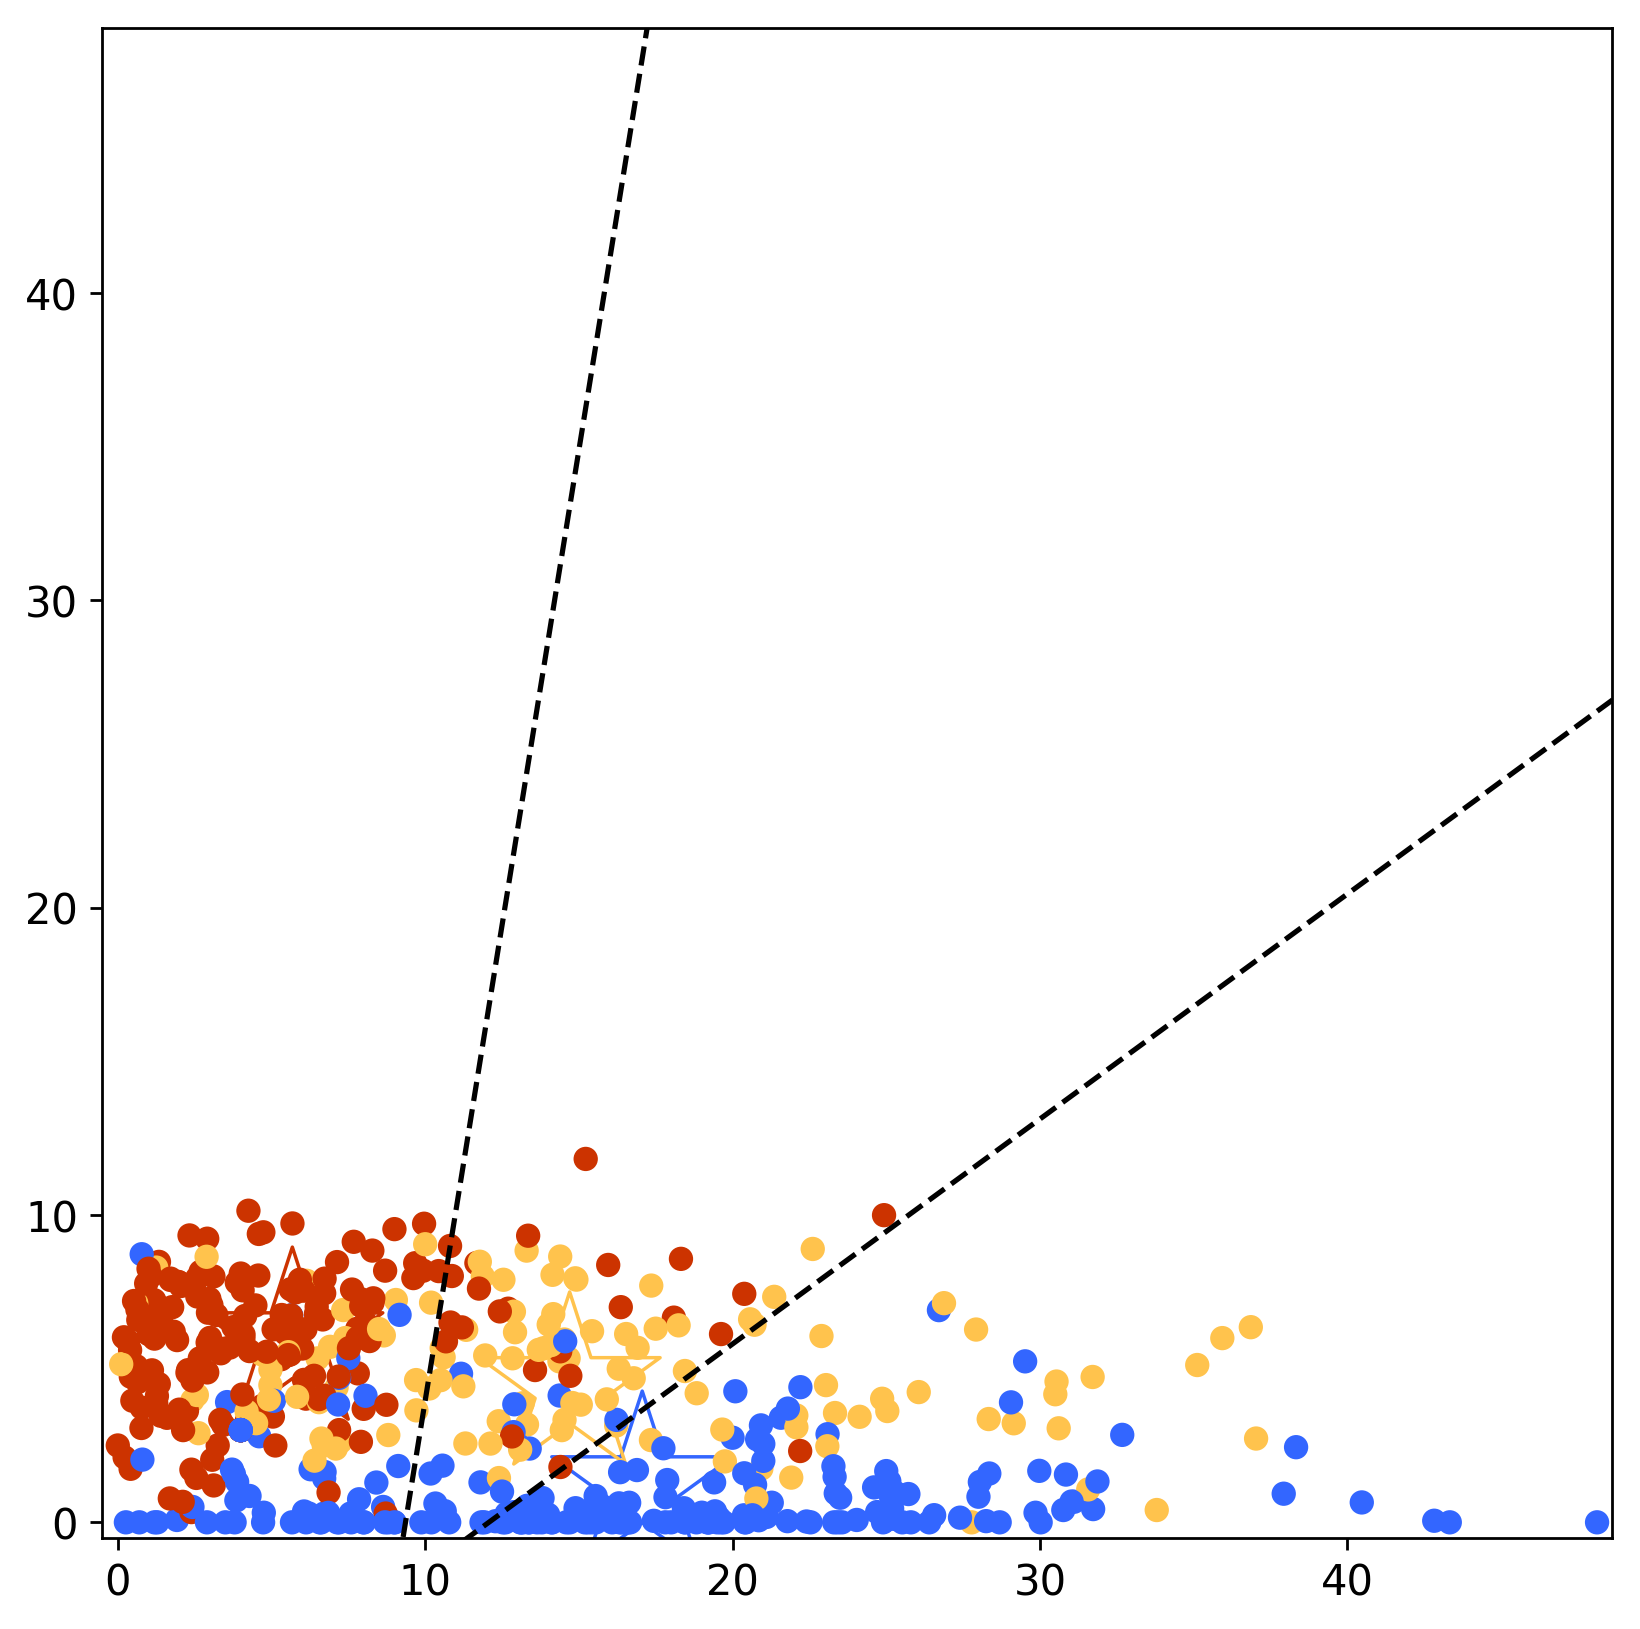

In [167]:
fig, ax = plt.subplots()
ax.scatter(centroids_1[:, 0], centroids_1[:, 1], edgecolors=class_colours, s=3000, facecolors='none',  marker='*')
ax.scatter(reduced_test_set_1[:,0], reduced_test_set_1[:,1], c=np.array([colour_map(int(cls)) for cls in reduced_test_set_1[:, 2]]))
plot_voronoi(centroids_1, reduced_test_set_1, ax)
fig.show()


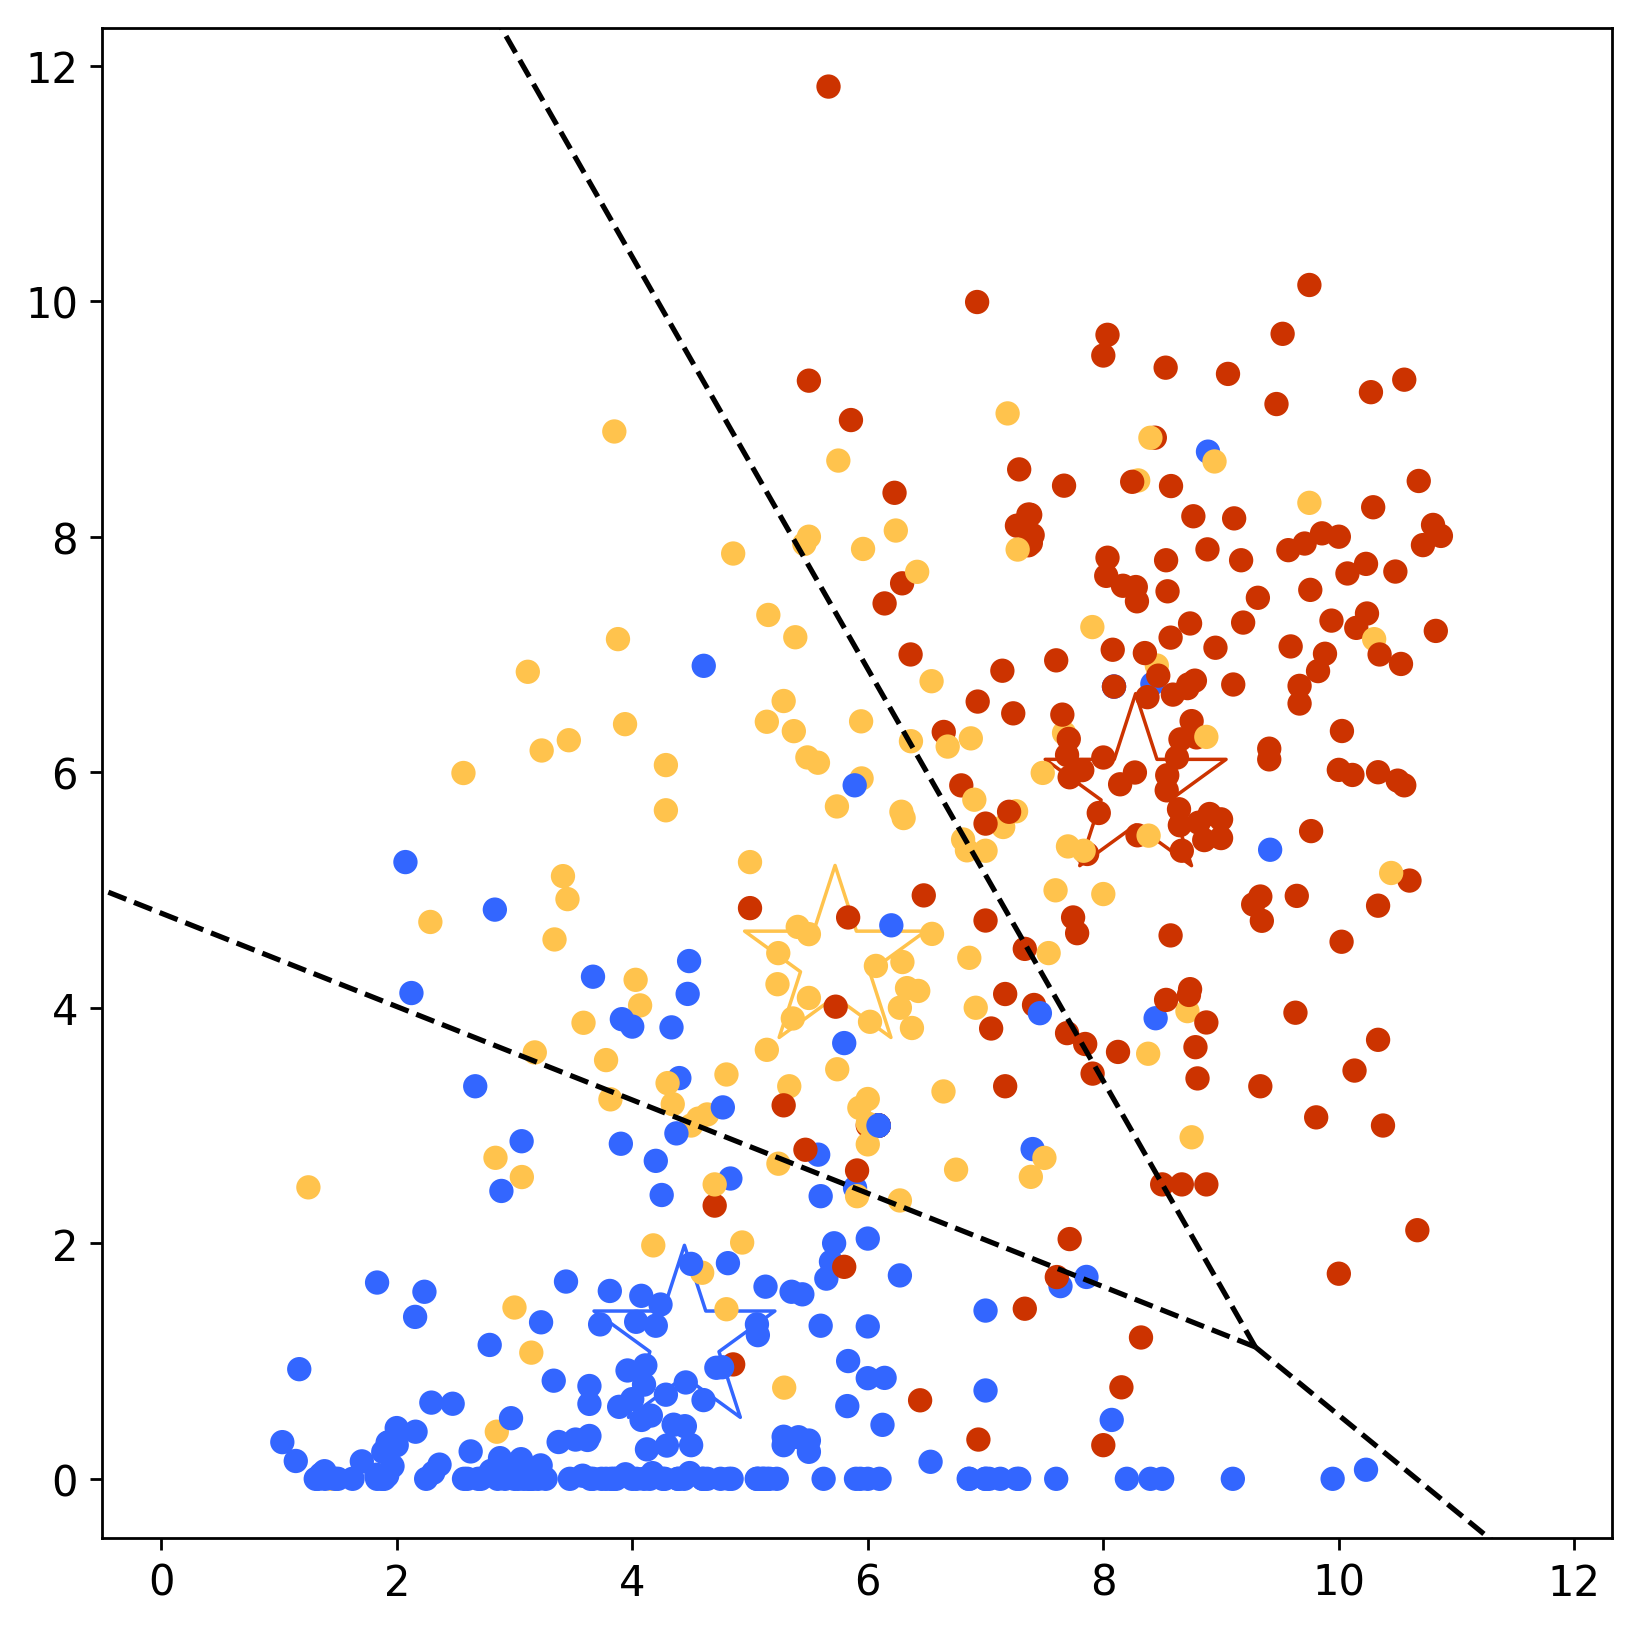

In [168]:
fig, ax = plt.subplots()
ax.scatter(centroids_2[:, 0], centroids_2[:, 1], edgecolors=class_colours, s=3000, facecolors='none',  marker='*')
ax.scatter(reduced_test_set_2[:,0], reduced_test_set_2[:,1], c=np.array([colour_map(int(cls)) for cls in reduced_test_set_2[:, 2]]))
plot_voronoi(centroids_2, reduced_test_set_2, ax)
fig.show()

## Evaluation

We can now evaluate how good the classifier is

### Accuracy

In [169]:
def calculate_accuracy(gt_labels, pred_labels):
    return ((gt_labels == pred_labels).sum()/gt_labels.shape[0])

print(calculate_accuracy(test_labels, test_set_results_1))

print(calculate_accuracy(test_labels, test_set_results_2))

0.6615969581749049
0.7604562737642585


### Confusion Matrix

In [170]:
def calculate_confusion_matrix(gt_labels, pred_labels, n=3):
    cm = np.zeros((n,n))
    for i in range(gt_labels.shape[0]):
        cm[int(gt_labels[i]), int(pred_labels[i])] += 1
        
    for i in range(n):
        class_count = (gt_labels == i).sum()
        cm[i,:] = cm[i,:]/class_count
    
    return cm


cm_1 = calculate_confusion_matrix(test_labels, test_set_results_1, n=3)
cm_2 = calculate_confusion_matrix(test_labels, test_set_results_2, n=3)

In [171]:
def plot_matrix(matrix, ax=None):
    """
    Displays a given matrix as an image.
    
    Args:
        - matrix: the matrix to be displayed        
        - ax: the matplotlib axis where to overlay the plot. 
          If you create the figure with `fig, fig_ax = plt.subplots()` simply pass `ax=fig_ax`. 
          If you do not explicitily create a figure, then pass no extra argument.  
          In this case the  current axis (i.e. `plt.gca())` will be used        
    """    
    if ax is None:
        ax = plt.gca()
    
    handle = ax.imshow(matrix, cmap=plt.get_cmap('summer'))
    plt.colorbar(handle)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, str(matrix[i, j])[:4])
        
    ax.set_xticks(range(matrix.shape[0]))
    ax.set_yticks(range(matrix.shape[1]))
    # write your code here
    


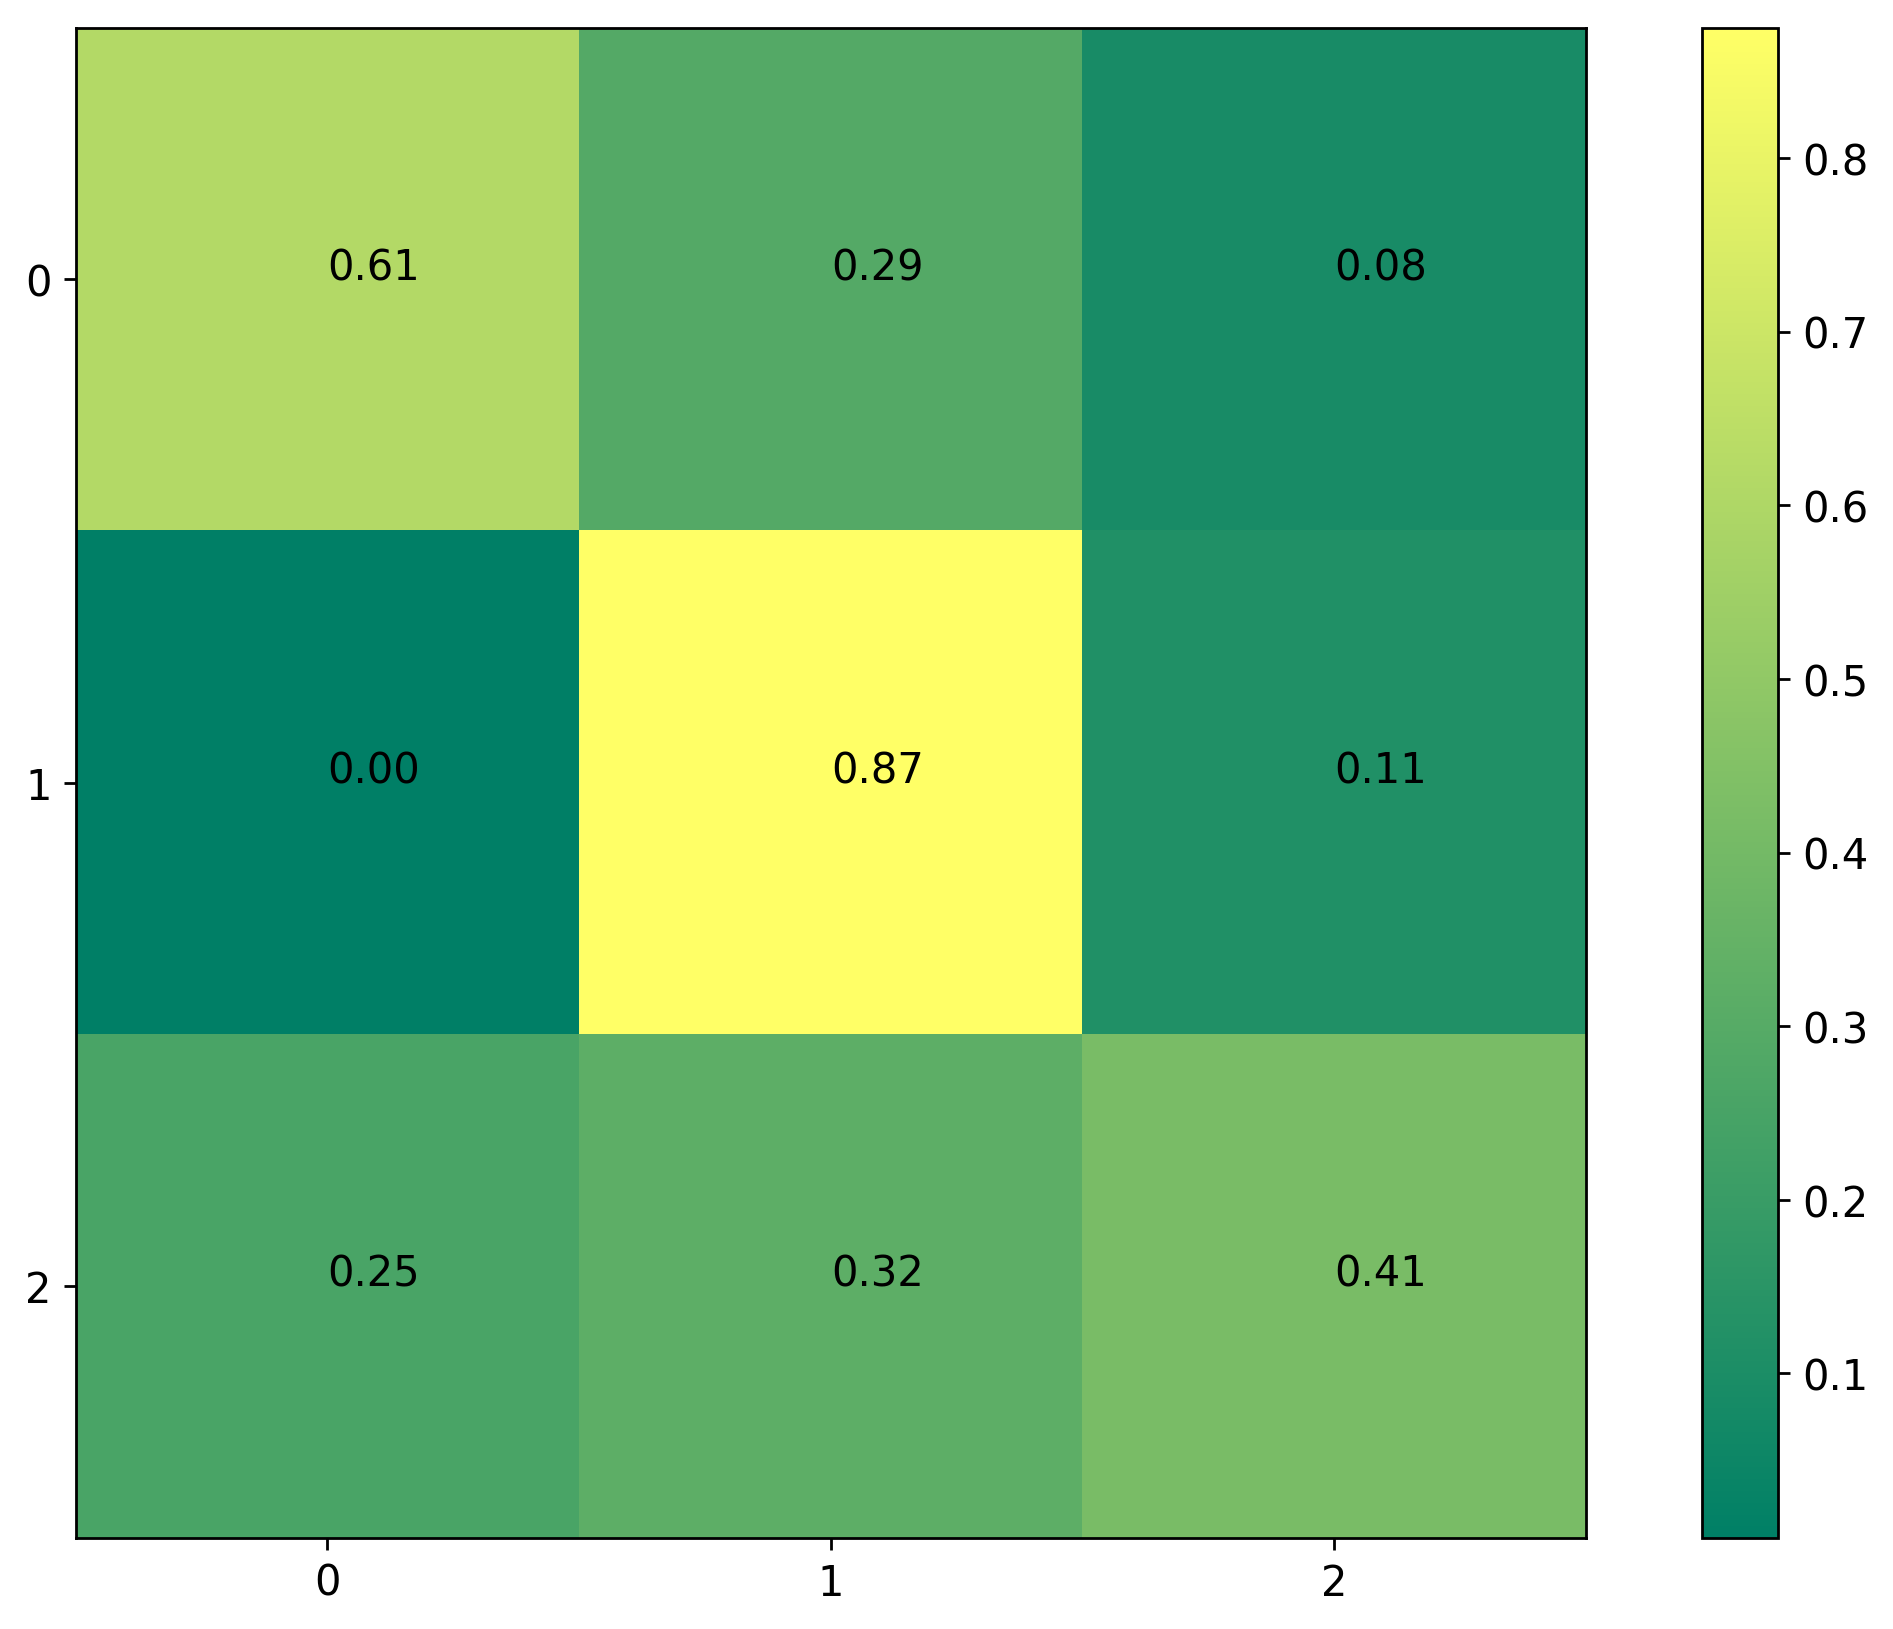

In [172]:
plot_matrix(cm_1)

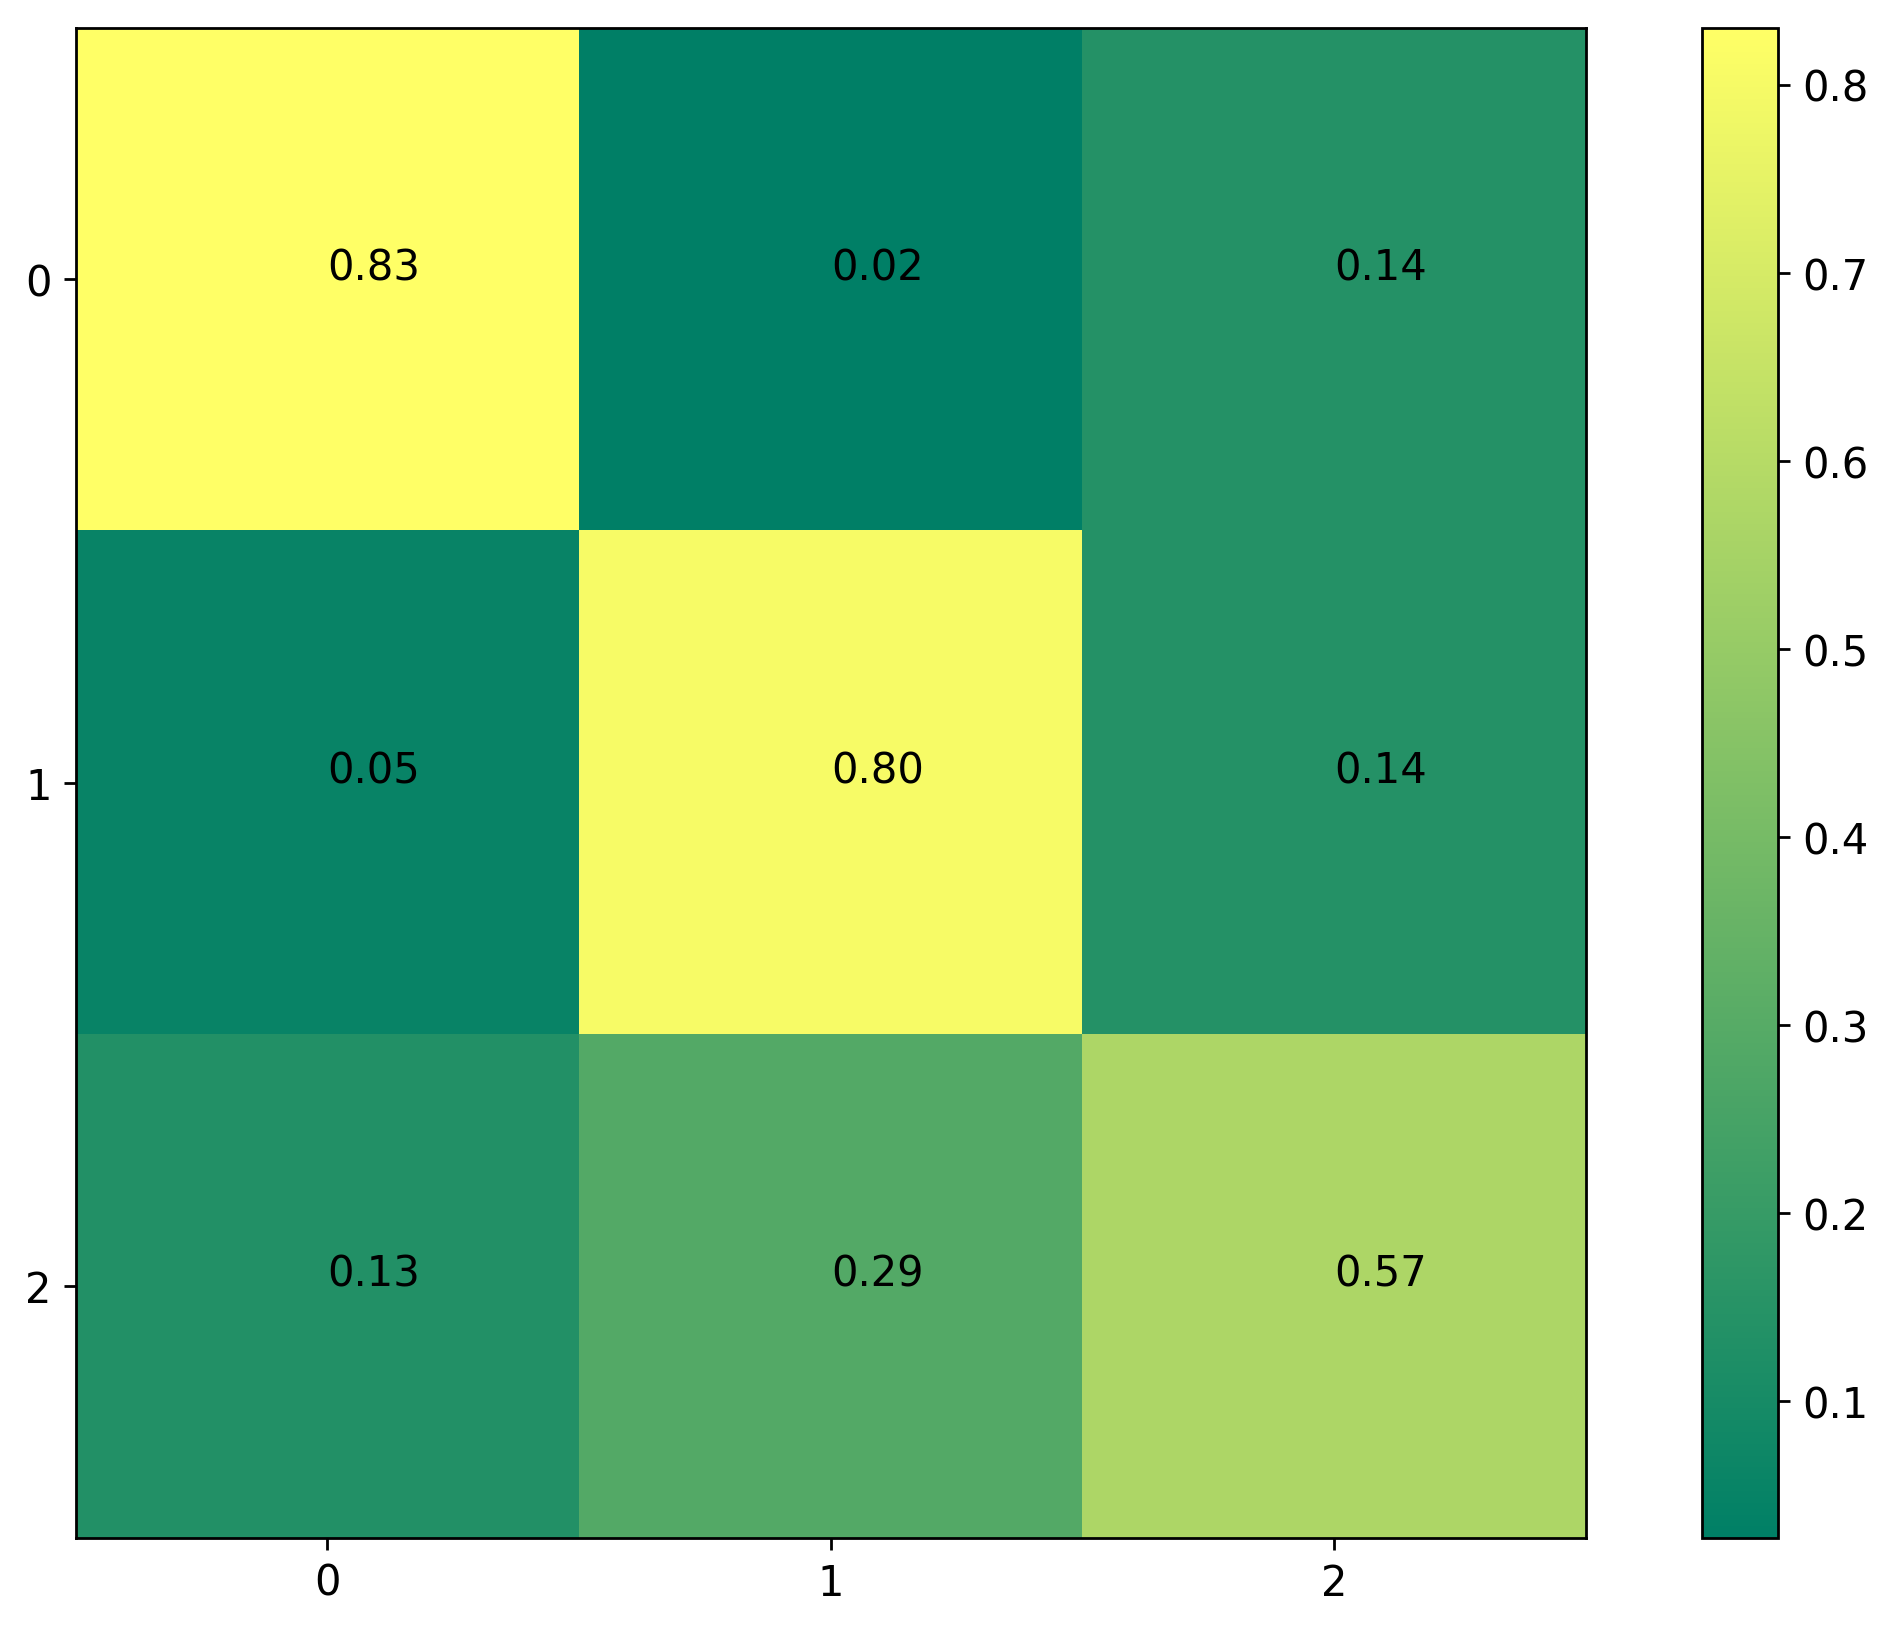

In [173]:
plot_matrix(cm_2)

In [174]:
print(centroids_1)
print(centroids_2)

[[17.0612474   1.17520041]
 [ 5.67839119  5.85979885]
 [14.70046957  4.40095124]]
[[4.44317865 1.17520041]
 [8.27449793 5.85979885]
 [5.7221887  4.40095124]]
